In [2]:
import numpy as np
import scipy.stats as ss
from scipy.stats import entropy
from scipy.integrate import quad
import pylab as plt
from collections import Counter
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from pyabc.examples import tuberculosis
import pyabc.prior
from pyabc.plots import plot_marginals, plot_particles, plot_pairs
%matplotlib notebook

In [3]:
path_to_data = "/home/michael/Dropbox/AppliedCognitiveModelling2017/ABC/03 data/"
#path_to_data = "C:\\Users\\Admin\\Dropbox\\AppliedCognitiveModelling2017\\ABC\\03 data"

In [14]:
def plot_for_report(
    list_of_sampler, 
    posterior=None, 
    posterior_mean = None,
    posterior_label = "reference posterior",
    legend_text=None,
    title_text=None, 
    xlabel=None, 
    ylabel=None, 
    savefig=False, 
    figname=None,
    no_spines = ["top", "bottom", "right", "left"],
    mark_means = True,
    calc_kl = False,
    plot_hist = False,
    **kw_hist
):
    """plot kde for each sampler and true posterior if available"""
    # These are the "Tableau 20" colors as RGB.    
    tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 


    # Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
    for i in range(len(tableau20)):    
        r, g, b = tableau20[i]    
        tableau20[i] = (r / 255., g / 255., b / 255.)  
    
    # plot for report
    # You typically want your plot to be ~1.33x wider than tall. This plot is a rare    
    # exception because of the number of lines being plotted on it.    
    # Common sizes: (10, 7.5) and (12, 9)    
    plt.figure(figsize=(10, 7.5)) 

    # Remove the plot frame lines. They are unnecessary chartjunk.    
    ax = plt.subplot(111)    
    for spine in no_spines:
        ax.spines[spine].set_visible(False)
        
    # Ensure that the axis ticks only show up on the bottom and left of the plot.    
    # Ticks on the right and top of the plot are generally unnecessary chartjunk.    
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()  
    ax.tick_params(axis='both', which='major', pad=15)

    #plot ABC posterior
    #xx = np.linspace(mu_0 - 3*sigma_0, mu_0 + 4*sigma_0, 200)
    x_min = np.inf
    x_max = -np.inf
    for i, sampler in enumerate(list_of_sampler):
        thetas = sampler.Thetas.flatten()
        xx = np.linspace(np.min(thetas) - 0.1, np.max(thetas) + 0.1, 200)
        if x_min > np.min(xx):
            x_min = np.min(xx)
        if x_max < np.max(xx):
            x_max = np.max(xx)
            
        # plot posterior
        #plt.hist(thetas, normed=True, alpha=0.2, color=tableau20[i*2], bins="auto")
        # plot KDE and MAP
        # get the bandwidth method argument for scipy
        # and run scipy's kde
        kde = ss.kde.gaussian_kde(thetas)
        dens = kde(xx)
        if legend_text is not None:
            plt.plot(xx, dens, color=tableau20[i*2], label=legend_text[i])
        else:
            plt.plot(xx, dens, color=tableau20[i*2])
        
        if plot_hist:
            plt.hist(thetas, normed=True, color=tableau20[i*2], **kw_hist)
        
        #mark means
        if mark_means:
            mean = np.mean(thetas)
            plt.plot(mean, 0, color=tableau20[i*2], marker="D")

    # plot ground truth posterior
    kl = []
    if posterior is not None:
        xx = np.linspace(x_min, x_max, 200)
        yy = posterior(xx)
        plt.plot(xx, yy, "m", label=posterior_label, linewidth=3, color="m")
        
        if mark_means:
            if posterior_mean is None:
                if mark_means:
                    mean, err = quad(lambda x : x * posterior(x), x_min-1, x_max+1)
                    print("posterior mean:", mean, "with error", err)
                    # find closest x
                    plt.plot(mean, 0, color="m", marker="D")
            else:
                plt.plot(posterior_mean, 0, color="m", marker="D")
                print("posterior mean:", posterior_mean)
            
        # calculate kullback leibler divergence
        if calc_kl:
            for i, sampler in enumerate(list_of_sampler):
                thetas = sampler.Thetas.flatten()
            
                # plot posterior
                #plt.hist(thetas, normed=True, alpha=0.2, color=tableau20[i*2], bins="auto")
                # plot KDE and MAP
                # get the bandwidth method argument for scipy
                # and run scipy's kde
                kde = ss.kde.gaussian_kde(thetas)
                kl.append(
                    entropy(
                        np.where(kde(xx) < 1e-50, 1e-50, kde(xx)),
                        np.where(posterior(xx) < 1e-50, 1e-50, posterior(xx))
                    )
                )
    
    if xlabel is not None:
        plt.xlabel(xlabel)
    else:
        plt.xlabel(r"$\theta$")
        
    if ylabel is not None:
        plt.ylabel(ylabel)
    else:
        plt.ylabel(r"$p(\theta|D)$")
    
    if title_text is not None:
        plt.title(title_text)
        
    plt.legend(fontsize=14)
    plt.gca().set_ylim(bottom=-0.1)
    
    if savefig:
        plt.savefig(figname, bbox_inches='tight')
        
    return kl

## Intractable model by Tanaka et al. 2006 for spread of tuberculosis

![](img/transmission_process.png)

### model parameter
$\alpha$: rate with which each infectious host randomly infects other individuals from an unlimited supply of hosts

$\delta$: rate with which a host stops being infectious, either by recovering or dying

$\tau$: rate with which the pathogen of the host mutates randomly within the host, generating a novel haplotype under a single-locus infinite alleles model

$\theta = (\alpha, \delta, \tau)$

$y_{\theta} = (6,3,2,2,1,1,1,1,1,1,1)$: output, vector of clusters, that is different haplotypes. Each number represents the infectious hosts for this particular haplotype

### Observation
$\alpha = 0.2, \delta = 0, \tau = 0.198, m = 20$

assume, that $\delta, \tau$ are known and apply uniform prior

In [5]:
alpha = 0.2
delta = 0
tau = 0.198
m = 20
N = 2e7

prior_alpha = pyabc.Prior("uniform", 0.005, 2, name=r"$\alpha$")
#prior_tau = pyabc.Prior("uniform", 0.01, 1, name="$\tau$")

list_of_priors = [prior_alpha]

simulator = tuberculosis.simulator

In [6]:
# for i in range(100):
#     params = [prior_alpha.sample(),prior_delta.sample(),prior_tau.sample()]
#     y0 = simulator(*params)

params = [alpha, tau, delta]



y0 = np.array([6,3,2,2,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0]) # from paper

T1
0.55
T2
0.85


<IPython.core.display.Javascript object>


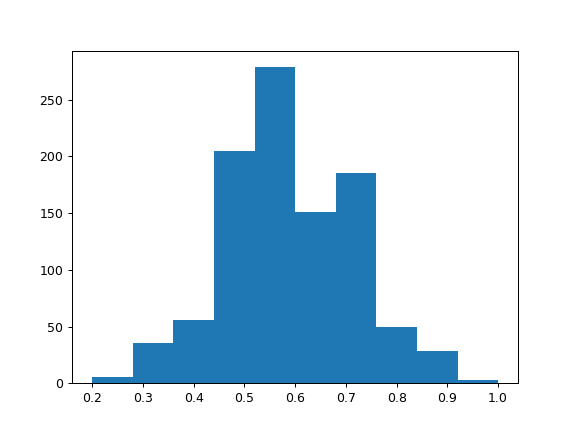

(array([   6.,   36.,   56.,  205.,  279.,  151.,  185.,   50.,   29.,    3.]),
 array([ 0.2 ,  0.28,  0.36,  0.44,  0.52,  0.6 ,  0.68,  0.76,  0.84,
         0.92,  1.  ]),
 <a list of 10 Patch objects>)

In [7]:
list_of_sum = tuberculosis.summaries
for f in list_of_sum:
    print(f.__name__)
    print(f(y0))
    
#summaries = tuberculosis.summaries
T = []
for i in range(1000):
    y = simulator(alpha)
    T.append(list_of_sum[0](y))
    
plt.hist(T)

### ABC with summary stats

In [8]:
summaries = [lambda x: x]
rej = pyabc.RejectionSampler(priors=list_of_priors, simulator=simulator, 
                             summaries=summaries,
                             observation=y0, seed = 1337, verbosity=2)
smc = pyabc.SMCSampler(priors=list_of_priors, simulator=simulator, 
                             summaries=summaries,
                             observation=y0, seed = 1337, verbosity=2)
mcmc = pyabc.MCMCSampler(priors=list_of_priors, simulator=simulator, 
                             summaries=summaries,
                             observation=y0, seed = 1337, verbosity=2)
#abcde = pyabc.ABCDESampler(priors=list_of_priors, simulator=simulator, 
#                             summaries=summaries,
#                             observation=y0, seed = 1337)

In [21]:
nr_samples, threshold = 200, 0
rej.sample(nr_samples=nr_samples, threshold=threshold)

fname = os.path.join(path_to_data, "ex02", "rej_{}_{}_v2.pkl".format(nr_samples, str(threshold).replace(".", "_")))
rej.save(fname)

Rejection sampler started with threshold: 0 and number of samples: 200
Samples:      5 /    200 (  2 %)- Threshold: 0.0000 - Iterations:       1000 - Acceptance rate: 0.005000 - Time:     2.83 s
Samples:      6 /    200 (  3 %)- Threshold: 0.0000 - Iterations:       2000 - Acceptance rate: 0.003000 - Time:     5.50 s
Samples:      8 /    200 (  4 %)- Threshold: 0.0000 - Iterations:       3000 - Acceptance rate: 0.002667 - Time:     8.18 s
Samples:      8 /    200 (  4 %)- Threshold: 0.0000 - Iterations:       4000 - Acceptance rate: 0.002000 - Time:    10.82 s
Samples:     10 /    200 (  5 %)- Threshold: 0.0000 - Iterations:       5000 - Acceptance rate: 0.002000 - Time:    13.42 s
Samples:     11 /    200 (  6 %)- Threshold: 0.0000 - Iterations:       6000 - Acceptance rate: 0.001833 - Time:    16.20 s
Samples:     14 /    200 (  7 %)- Threshold: 0.0000 - Iterations:       7000 - Acceptance rate: 0.002000 - Time:    18.77 s
Samples:     15 /    200 (  8 %)- Threshold: 0.0000 - Iterati

Samples:    147 /    200 ( 74 %)- Threshold: 0.0000 - Iterations:      67000 - Acceptance rate: 0.002194 - Time:   183.07 s
Samples:    149 /    200 ( 74 %)- Threshold: 0.0000 - Iterations:      68000 - Acceptance rate: 0.002191 - Time:   185.77 s
Samples:    152 /    200 ( 76 %)- Threshold: 0.0000 - Iterations:      69000 - Acceptance rate: 0.002203 - Time:   188.52 s
Samples:    152 /    200 ( 76 %)- Threshold: 0.0000 - Iterations:      70000 - Acceptance rate: 0.002171 - Time:   191.01 s
Samples:    156 /    200 ( 78 %)- Threshold: 0.0000 - Iterations:      71000 - Acceptance rate: 0.002197 - Time:   193.88 s
Samples:    157 /    200 ( 78 %)- Threshold: 0.0000 - Iterations:      72000 - Acceptance rate: 0.002181 - Time:   196.47 s
Samples:    160 /    200 ( 80 %)- Threshold: 0.0000 - Iterations:      73000 - Acceptance rate: 0.002192 - Time:   199.52 s
Samples:    162 /    200 ( 81 %)- Threshold: 0.0000 - Iterations:      74000 - Acceptance rate: 0.002189 - Time:   202.39 s
Samples:

In [18]:
#load data
rej = pyabc.RejectionSampler.load(os.path.join(path_to_data, "ex02", "rej_10000_0.pkl"))

print(rej.threshold)
print(rej.Thetas.shape)
print(rej.Thetas.mean())
print(rej.runtime)
print(rej.acceptance_rate)
print(rej.nr_iter)

0
(10000, 1)
0.325388173177
11981.297611562404
0.0019755037534571317
5062000


In [ ]:
nr_samples, thresholds = 10000, np.linspace(4, 0, 5)
smc.sample(nr_samples=nr_samples, thresholds=thresholds)

fname = os.path.join(path_to_data, "ex02", "smc_{}_{}.pkl".format(nr_samples, str(thresholds[-1]).replace(".", "_")))
smc.save(fname)

In [19]:
#load smc
#load data
smc = pyabc.SMCSampler.load(os.path.join(path_to_data, "ex02", "smc_10000_0_0.pkl"))

print(smc.thresholds)
print(smc.runtime)
print(smc.acceptance_rate)
print(smc.nr_iter)
print(smc.Thetas.mean())

[ 4.  3.  2.  1.  0.]
15694.483501727462
0.0031849588407769007
3139758
0.286618218398


In [10]:
nr_samples, threshold, step_size = 200, 0, [0.05]
mcmc.sample(nr_samples=nr_samples, threshold=threshold, step_size = step_size)

fname = os.path.join(
    path_to_data, "ex02", "mcmc_{}_{}_{}_v2.pkl".format(
        nr_samples, 
        str(threshold).replace(".", "_"), 
        str(step_size[0]).replace(".", "_")
    )
)
                     
mcmc.save(fname)

MCMC sampler started with threshold: 0 and number of samples: 200
Samples:     10 - Threshold: 0.0000 - Iterations:       4130 - Acceptance rate: 0.002421 - Time:    11.75 s
Samples:      1 /    200 (  0 %)- Threshold: 0.0000 - Iterations:       1000 - Acceptance rate: 0.200000 - Time:    14.87 s
Samples:      9 /    200 (  4 %)- Threshold: 0.0000 - Iterations:       2000 - Acceptance rate: 0.100000 - Time:    18.93 s
Samples:     19 /    200 ( 10 %)- Threshold: 0.0000 - Iterations:       3000 - Acceptance rate: 0.066667 - Time:    23.18 s
Samples:     26 /    200 ( 13 %)- Threshold: 0.0000 - Iterations:       4000 - Acceptance rate: 0.050000 - Time:    27.75 s
Samples:     34 /    200 ( 17 %)- Threshold: 0.0000 - Iterations:       5000 - Acceptance rate: 0.040000 - Time:    32.16 s
Samples:     37 /    200 ( 18 %)- Threshold: 0.0000 - Iterations:       6000 - Acceptance rate: 0.033333 - Time:    36.85 s
Samples:     43 /    200 ( 22 %)- Threshold: 0.0000 - Iterations:       7000 - Acc

In [20]:
#load data
mcmc = pyabc.MCMCSampler.load(os.path.join(path_to_data, "ex02", "mcmc_10000_0_0_1.pkl"))


print(mcmc.threshold)
#print(mcmc.step_size)
print(mcmc.runtime)
print(mcmc.acceptance_rate)
print(mcmc.nr_iter)
print(mcmc.Thetas.mean())

0
6879.1786185807105
0.006143351419359912
1627776
0.294718257024


<IPython.core.display.Javascript object>


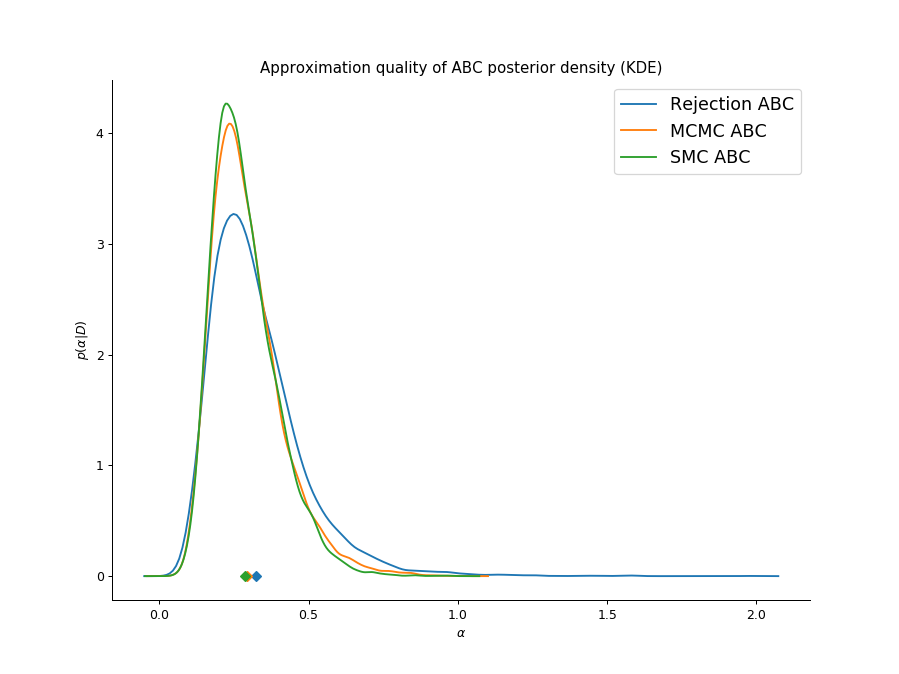

[]

In [53]:
rej = pyabc.RejectionSampler.load(os.path.join(path_to_data, "ex02", "rej_10000_0.pkl"))
mcmc = pyabc.MCMCSampler.load(os.path.join(path_to_data, "ex02", "mcmc_10000_0_0_1.pkl"))
smc = pyabc.SMCSampler.load(os.path.join(path_to_data, "ex02", "smc_10000_0_0.pkl"))

legend = ["Rejection ABC", "MCMC ABC", "SMC ABC"]
plot_for_report(
    list_of_sampler = [rej, mcmc, smc], 
    posterior=None, 
    posterior_mean=None,
    legend_text=legend, 
    title_text="Approximation quality of ABC posterior density (KDE)", 
    xlabel=r"$\alpha$", 
    ylabel=r"$p(\alpha|D)$",
    savefig=True,
    figname="ex02_3_abc_methods.pdf",
    no_spines=["top", "right"],
    mark_means=True,
    calc_kl=True
)

## Influence of Summary Stats

In [12]:
T_1, T_2 = tuberculosis.summaries

In [13]:
T_1(y0)

0.55

In [14]:
T_2(y0)

0.84999999999999998

## T1 

In [8]:
T_1, T_2 = tuberculosis.summaries
rej = pyabc.RejectionSampler(priors=list_of_priors, simulator=simulator, 
                             summaries=[T_1],
                             observation=y0, seed = 1337, verbosity=2)
smc = pyabc.SMCSampler(priors=list_of_priors, simulator=simulator, 
                             summaries=[T_1],
                             observation=y0, seed = 1337, verbosity=2)
mcmc = pyabc.MCMCSampler(priors=list_of_priors, simulator=simulator, 
                         summaries=[T_1], 
                         observation=y0, seed = 1337, verbosity=2)

In [9]:
rej.sample(nr_samples=10000, threshold=0.2)
rej.save(os.path.join(path_to_data, "ex02", "rej_T1_10000_0_2.pkl"))

rej.sample(nr_samples=10000, threshold=0.1)
rej.save(os.path.join(path_to_data, "ex02", "rej_T1_10000_0_1.pkl"))

rej.sample(nr_samples=10000, threshold=0.05)
rej.save(os.path.join(path_to_data, "ex02", "rej_T1_10000_0_05.pkl"))

Rejection sampler started with threshold: 0.2 and number of samples: 10000
Samples:    201 /  10000 (  2 %)- Threshold: 0.2000 - Iterations:       1000 - Acceptance rate: 0.201000 - Time:     3.51 s
Samples:    396 /  10000 (  4 %)- Threshold: 0.2000 - Iterations:       2000 - Acceptance rate: 0.198000 - Time:     6.81 s
Samples:    583 /  10000 (  6 %)- Threshold: 0.2000 - Iterations:       3000 - Acceptance rate: 0.194333 - Time:     9.68 s
Samples:    780 /  10000 (  8 %)- Threshold: 0.2000 - Iterations:       4000 - Acceptance rate: 0.195000 - Time:    12.42 s
Samples:    992 /  10000 ( 10 %)- Threshold: 0.2000 - Iterations:       5000 - Acceptance rate: 0.198400 - Time:    15.19 s
Samples:   1209 /  10000 ( 12 %)- Threshold: 0.2000 - Iterations:       6000 - Acceptance rate: 0.201500 - Time:    17.84 s
Samples:   1400 /  10000 ( 14 %)- Threshold: 0.2000 - Iterations:       7000 - Acceptance rate: 0.200000 - Time:    20.63 s
Samples:   1601 /  10000 ( 16 %)- Threshold: 0.2000 - Ite

Samples:   1208 /  10000 ( 12 %)- Threshold: 0.1000 - Iterations:      14000 - Acceptance rate: 0.086286 - Time:    39.54 s
Samples:   1306 /  10000 ( 13 %)- Threshold: 0.1000 - Iterations:      15000 - Acceptance rate: 0.087067 - Time:    42.27 s
Samples:   1390 /  10000 ( 14 %)- Threshold: 0.1000 - Iterations:      16000 - Acceptance rate: 0.086875 - Time:    44.86 s
Samples:   1486 /  10000 ( 15 %)- Threshold: 0.1000 - Iterations:      17000 - Acceptance rate: 0.087412 - Time:    47.48 s
Samples:   1575 /  10000 ( 16 %)- Threshold: 0.1000 - Iterations:      18000 - Acceptance rate: 0.087500 - Time:    50.43 s
Samples:   1651 /  10000 ( 17 %)- Threshold: 0.1000 - Iterations:      19000 - Acceptance rate: 0.086895 - Time:    53.32 s
Samples:   1757 /  10000 ( 18 %)- Threshold: 0.1000 - Iterations:      20000 - Acceptance rate: 0.087850 - Time:    56.14 s
Samples:   1853 /  10000 ( 19 %)- Threshold: 0.1000 - Iterations:      21000 - Acceptance rate: 0.088238 - Time:    59.03 s
Samples:

Samples:   7257 /  10000 ( 73 %)- Threshold: 0.1000 - Iterations:      81000 - Acceptance rate: 0.089593 - Time:   277.24 s
Samples:   7349 /  10000 ( 73 %)- Threshold: 0.1000 - Iterations:      82000 - Acceptance rate: 0.089622 - Time:   279.93 s
Samples:   7438 /  10000 ( 74 %)- Threshold: 0.1000 - Iterations:      83000 - Acceptance rate: 0.089614 - Time:   282.75 s
Samples:   7525 /  10000 ( 75 %)- Threshold: 0.1000 - Iterations:      84000 - Acceptance rate: 0.089583 - Time:   285.45 s
Samples:   7614 /  10000 ( 76 %)- Threshold: 0.1000 - Iterations:      85000 - Acceptance rate: 0.089576 - Time:   288.21 s
Samples:   7702 /  10000 ( 77 %)- Threshold: 0.1000 - Iterations:      86000 - Acceptance rate: 0.089558 - Time:   291.08 s
Samples:   7788 /  10000 ( 78 %)- Threshold: 0.1000 - Iterations:      87000 - Acceptance rate: 0.089517 - Time:   293.78 s
Samples:   7883 /  10000 ( 79 %)- Threshold: 0.1000 - Iterations:      88000 - Acceptance rate: 0.089580 - Time:   296.45 s
Samples:

Samples:   1420 /  10000 ( 14 %)- Threshold: 0.0500 - Iterations:      32000 - Acceptance rate: 0.044375 - Time:    88.85 s
Samples:   1462 /  10000 ( 15 %)- Threshold: 0.0500 - Iterations:      33000 - Acceptance rate: 0.044303 - Time:    93.33 s
Samples:   1505 /  10000 ( 15 %)- Threshold: 0.0500 - Iterations:      34000 - Acceptance rate: 0.044265 - Time:   111.04 s
Samples:   1548 /  10000 ( 15 %)- Threshold: 0.0500 - Iterations:      35000 - Acceptance rate: 0.044229 - Time:   142.34 s
Samples:   1580 /  10000 ( 16 %)- Threshold: 0.0500 - Iterations:      36000 - Acceptance rate: 0.043889 - Time:   176.26 s
Samples:   1625 /  10000 ( 16 %)- Threshold: 0.0500 - Iterations:      37000 - Acceptance rate: 0.043919 - Time:   200.51 s
Samples:   1673 /  10000 ( 17 %)- Threshold: 0.0500 - Iterations:      38000 - Acceptance rate: 0.044026 - Time:   210.05 s
Samples:   1723 /  10000 ( 17 %)- Threshold: 0.0500 - Iterations:      39000 - Acceptance rate: 0.044179 - Time:   216.15 s
Samples:

Samples:   4213 /  10000 ( 42 %)- Threshold: 0.0500 - Iterations:      99000 - Acceptance rate: 0.042556 - Time:   437.78 s
Samples:   4255 /  10000 ( 43 %)- Threshold: 0.0500 - Iterations:     100000 - Acceptance rate: 0.042550 - Time:   440.49 s
Samples:   4287 /  10000 ( 43 %)- Threshold: 0.0500 - Iterations:     101000 - Acceptance rate: 0.042446 - Time:   443.19 s
Samples:   4327 /  10000 ( 43 %)- Threshold: 0.0500 - Iterations:     102000 - Acceptance rate: 0.042422 - Time:   445.88 s
Samples:   4372 /  10000 ( 44 %)- Threshold: 0.0500 - Iterations:     103000 - Acceptance rate: 0.042447 - Time:   448.54 s
Samples:   4413 /  10000 ( 44 %)- Threshold: 0.0500 - Iterations:     104000 - Acceptance rate: 0.042433 - Time:   451.22 s
Samples:   4463 /  10000 ( 45 %)- Threshold: 0.0500 - Iterations:     105000 - Acceptance rate: 0.042505 - Time:   453.96 s
Samples:   4506 /  10000 ( 45 %)- Threshold: 0.0500 - Iterations:     106000 - Acceptance rate: 0.042509 - Time:   456.46 s
Samples:

Samples:   7099 /  10000 ( 71 %)- Threshold: 0.0500 - Iterations:     166000 - Acceptance rate: 0.042765 - Time:   675.93 s
Samples:   7137 /  10000 ( 71 %)- Threshold: 0.0500 - Iterations:     167000 - Acceptance rate: 0.042737 - Time:   678.57 s
Samples:   7173 /  10000 ( 72 %)- Threshold: 0.0500 - Iterations:     168000 - Acceptance rate: 0.042696 - Time:   681.25 s
Samples:   7223 /  10000 ( 72 %)- Threshold: 0.0500 - Iterations:     169000 - Acceptance rate: 0.042740 - Time:   683.93 s
Samples:   7267 /  10000 ( 73 %)- Threshold: 0.0500 - Iterations:     170000 - Acceptance rate: 0.042747 - Time:   686.43 s
Samples:   7301 /  10000 ( 73 %)- Threshold: 0.0500 - Iterations:     171000 - Acceptance rate: 0.042696 - Time:   689.27 s
Samples:   7337 /  10000 ( 73 %)- Threshold: 0.0500 - Iterations:     172000 - Acceptance rate: 0.042657 - Time:   691.89 s
Samples:   7380 /  10000 ( 74 %)- Threshold: 0.0500 - Iterations:     173000 - Acceptance rate: 0.042659 - Time:   694.67 s
Samples:

Samples:   9925 /  10000 ( 99 %)- Threshold: 0.0500 - Iterations:     233000 - Acceptance rate: 0.042597 - Time:   956.57 s
Samples:   9967 /  10000 (100 %)- Threshold: 0.0500 - Iterations:     234000 - Acceptance rate: 0.042594 - Time:   959.11 s
Samples:  10023 /  10000 (100 %)- Threshold: 0.0500 - Iterations:     235000 - Acceptance rate: 0.042651 - Time:   961.67 s
Samples:  10000 - Threshold: 0.0500 - Iterations:     235000 - Acceptance rate: 0.042553 - Time:   961.67 s


<IPython.core.display.Javascript object>


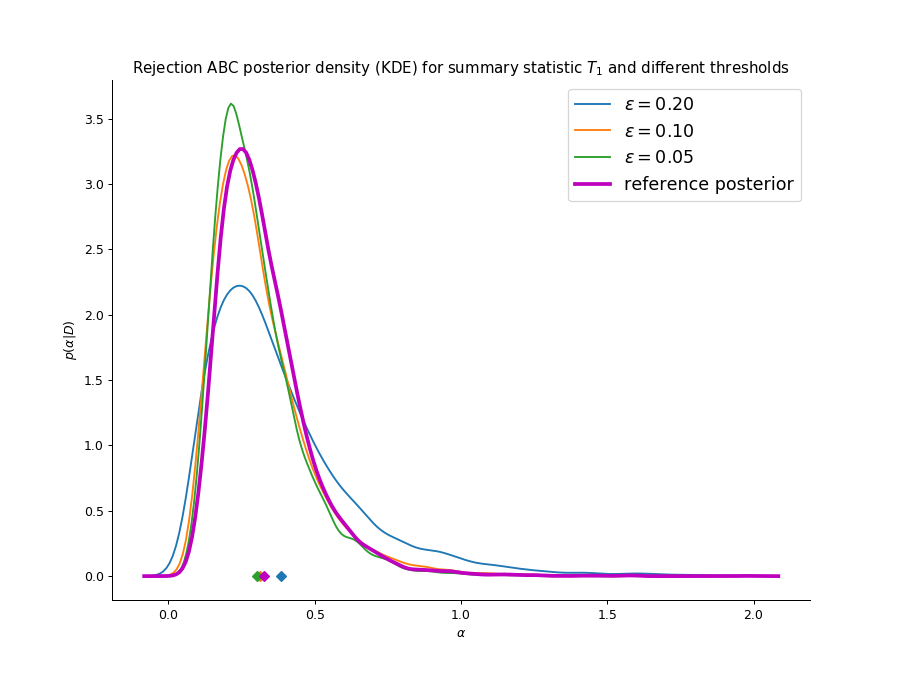

posterior mean: 0.32538817317815694 with error 4.203173796111305e-09


[0.20705927039757982, 0.027239802153877134, 0.017655315971340919]

In [28]:
rej_1 = pyabc.RejectionSampler.load(os.path.join(path_to_data, "ex02", "rej_T1_10000_0_2.pkl"))
rej_2 = pyabc.RejectionSampler.load(os.path.join(path_to_data, "ex02", "rej_T1_10000_0_1.pkl"))
rej_3 = pyabc.RejectionSampler.load(os.path.join(path_to_data, "ex02", "rej_T1_10000_0_05.pkl"))

rej = pyabc.RejectionSampler.load(os.path.join(path_to_data, "ex02", "rej_10000_0.pkl"))

def reference(x):
    sampler = pyabc.RejectionSampler.load(os.path.join(path_to_data, "ex02", "rej_10000_0.pkl"))
    theta = sampler.Thetas.flatten()
    kde = ss.kde.gaussian_kde(theta)
    return kde(x)
    

legend = [r"$\epsilon=0.20$", r"$\epsilon=0.10$", r"$\epsilon=0.05$"]
plot_for_report(
    list_of_sampler = [rej_1, rej_2, rej_3], 
    posterior=reference, 
    posterior_mean = None,
    legend_text=legend, 
    title_text="Rejection ABC posterior density (KDE) for summary statistic $T_1$ and different thresholds", 
    xlabel=r"$\alpha$", 
    ylabel=r"$p(\alpha|D)$",
    savefig=True,
    figname="ex02_rej_abc_T1.pdf",
    no_spines=["top", "right"],
    mark_means=True,
    calc_kl=True
)

In [26]:
rej_3.nr_iter

235000

In [32]:
rej.Thetas.mean()

0.32538817317727931

In [31]:
abs(rej_3.Thetas.mean() - rej.Thetas.mean())

0.022904170829212145

## T2

In [12]:
T_1, T_2 = tuberculosis.summaries
rej = pyabc.RejectionSampler(priors=list_of_priors, simulator=simulator, 
                             summaries=[T_2],
                             observation=y0, seed = 1337, verbosity=2)
smc = pyabc.SMCSampler(priors=list_of_priors, simulator=simulator, 
                             summaries=[T_2],
                             observation=y0, seed = 1337, verbosity=2)
mcmc = pyabc.MCMCSampler(priors=list_of_priors, simulator=simulator, 
                         summaries=[T_2], 
                         observation=y0, seed = 1337, verbosity=2)

In [13]:
rej.sample(nr_samples=10000, threshold=0.2)
rej.save(os.path.join(path_to_data, "ex02", "rej_T2_10000_0_2.pkl"))

rej.sample(nr_samples=10000, threshold=0.1)
rej.save(os.path.join(path_to_data, "ex02", "rej_T2_10000_0_1.pkl"))

rej.sample(nr_samples=10000, threshold=0.05)
rej.save(os.path.join(path_to_data, "ex02", "rej_T2_10000_0_05.pkl"))

Rejection sampler started with threshold: 0.2 and number of samples: 10000
Samples:    383 /  10000 (  4 %)- Threshold: 0.2000 - Iterations:       1000 - Acceptance rate: 0.383000 - Time:     2.98 s
Samples:    772 /  10000 (  8 %)- Threshold: 0.2000 - Iterations:       2000 - Acceptance rate: 0.386000 - Time:     5.96 s
Samples:   1145 /  10000 ( 11 %)- Threshold: 0.2000 - Iterations:       3000 - Acceptance rate: 0.381667 - Time:     8.64 s
Samples:   1535 /  10000 ( 15 %)- Threshold: 0.2000 - Iterations:       4000 - Acceptance rate: 0.383750 - Time:    11.75 s
Samples:   1920 /  10000 ( 19 %)- Threshold: 0.2000 - Iterations:       5000 - Acceptance rate: 0.384000 - Time:    14.69 s
Samples:   2306 /  10000 ( 23 %)- Threshold: 0.2000 - Iterations:       6000 - Acceptance rate: 0.384333 - Time:    17.32 s
Samples:   2674 /  10000 ( 27 %)- Threshold: 0.2000 - Iterations:       7000 - Acceptance rate: 0.382000 - Time:    20.06 s
Samples:   3036 /  10000 ( 30 %)- Threshold: 0.2000 - Ite

Samples:  10024 /  10000 (100 %)- Threshold: 0.1000 - Iterations:      38000 - Acceptance rate: 0.263789 - Time:   103.72 s
Samples:  10000 - Threshold: 0.1000 - Iterations:      38000 - Acceptance rate: 0.263158 - Time:   103.72 s
Rejection sampler started with threshold: 0.05 and number of samples: 10000
Samples:    119 /  10000 (  1 %)- Threshold: 0.0500 - Iterations:       1000 - Acceptance rate: 0.119000 - Time:     2.67 s
Samples:    236 /  10000 (  2 %)- Threshold: 0.0500 - Iterations:       2000 - Acceptance rate: 0.118000 - Time:     5.25 s
Samples:    357 /  10000 (  4 %)- Threshold: 0.0500 - Iterations:       3000 - Acceptance rate: 0.119000 - Time:     7.84 s
Samples:    461 /  10000 (  5 %)- Threshold: 0.0500 - Iterations:       4000 - Acceptance rate: 0.115250 - Time:    10.70 s
Samples:    564 /  10000 (  6 %)- Threshold: 0.0500 - Iterations:       5000 - Acceptance rate: 0.112800 - Time:    13.54 s
Samples:    689 /  10000 (  7 %)- Threshold: 0.0500 - Iterations:       

Samples:   7641 /  10000 ( 76 %)- Threshold: 0.0500 - Iterations:      65000 - Acceptance rate: 0.117554 - Time:   175.87 s
Samples:   7755 /  10000 ( 78 %)- Threshold: 0.0500 - Iterations:      66000 - Acceptance rate: 0.117500 - Time:   178.52 s
Samples:   7866 /  10000 ( 79 %)- Threshold: 0.0500 - Iterations:      67000 - Acceptance rate: 0.117403 - Time:   181.05 s
Samples:   7981 /  10000 ( 80 %)- Threshold: 0.0500 - Iterations:      68000 - Acceptance rate: 0.117368 - Time:   183.76 s
Samples:   8102 /  10000 ( 81 %)- Threshold: 0.0500 - Iterations:      69000 - Acceptance rate: 0.117420 - Time:   186.50 s
Samples:   8210 /  10000 ( 82 %)- Threshold: 0.0500 - Iterations:      70000 - Acceptance rate: 0.117286 - Time:   189.21 s
Samples:   8321 /  10000 ( 83 %)- Threshold: 0.0500 - Iterations:      71000 - Acceptance rate: 0.117197 - Time:   191.77 s
Samples:   8435 /  10000 ( 84 %)- Threshold: 0.0500 - Iterations:      72000 - Acceptance rate: 0.117153 - Time:   194.64 s
Samples:

<IPython.core.display.Javascript object>


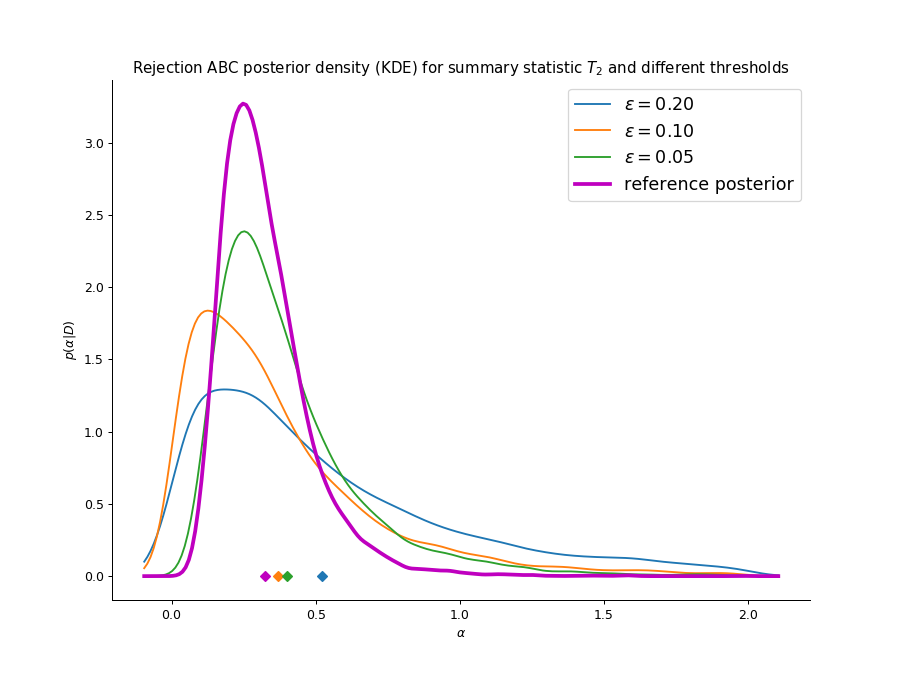

posterior mean: 0.3253881731777607 with error 2.2976480835748405e-09


[1.4727077516374996, 0.97110248337344673, 0.16886701823309655]

In [33]:
rej_1 = pyabc.RejectionSampler.load(os.path.join(path_to_data, "ex02", "rej_T2_10000_0_2.pkl"))
rej_2 = pyabc.RejectionSampler.load(os.path.join(path_to_data, "ex02", "rej_T2_10000_0_1.pkl"))
rej_3 = pyabc.RejectionSampler.load(os.path.join(path_to_data, "ex02", "rej_T2_10000_0_05.pkl"))

def reference(x):
    sampler = pyabc.MCMCSampler.load(os.path.join(path_to_data, "ex02", "rej_10000_0.pkl"))
    theta = sampler.Thetas.flatten()
    kde = ss.kde.gaussian_kde(theta)
    return kde(x)
    

legend = [r"$\epsilon=0.20$", r"$\epsilon=0.10$", r"$\epsilon=0.05$"]
plot_for_report(
    list_of_sampler = [rej_1, rej_2, rej_3], 
    posterior=reference, 
    posterior_mean = None,
    legend_text=legend, 
    title_text="Rejection ABC posterior density (KDE) for summary statistic $T_2$ and different thresholds", 
    xlabel=r"$\alpha$", 
    ylabel=r"$p(\alpha|D)$",
    savefig=True,
    figname="ex02_rej_abc_T2.pdf",
    no_spines=["top", "right"],
    mark_means=True,
    calc_kl=True
)

In [36]:
rej_3.nr_iter

86000

In [43]:
abs(rej_3.Thetas.mean() - rej.Thetas.mean())

0.073806680511194489

# BOLFI

In [1]:
list_of_priors

NameError: name 'list_of_priors' is not defined

In [ ]:
bolfi = pyabc.BOLFI(priors=list_of_priors, simulator=simulator, 
                             summaries=summaries,
                             observation=y0, domain=[(0.005, 2.005)], seed = 1337)



In [ ]:
bolfi.sample(nr_samples=1_000, threshold=2, initial_evidence_size=10, max_iter=100, n_chains=4, burn_in=100)

In [ ]:
plot_marginals(bolfi, xlim=[[-0.2, 1.2]])

In [ ]:
import elfi

In [ ]:
elfi.new_model()

p = elfi.Prior('uniform', 0.005, 2)

def sim(x, batch_size, random_state):
    return simulator(x)

Y = elfi.Simulator(sim, p, observed=y0)

s = elfi.Summary(lambda x: x, Y)

d = elfi.Distance('euclidean', s)

elfi.draw(d)

In [ ]:
elfibolfi = elfi.BOLFI(d, batch_size=1, initial_evidence=10, update_interval=10,
                   bounds={'p': (0.005, 2.005)}, acq_noise_var=[0.1], seed=101)

In [ ]:
post = elfibolfi.fit(n_evidence=200, threshold=2)

In [ ]:
result_elfi = elfibolfi.sample(1000, info_freq=1000)

In [ ]:
result_elfi.plot_marginals(normed=True)